In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import os
import sys 
import statsmodels as sm
import statsmodels.api as smapi
import statsmodels.regression.linear_model as lm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns
from fbprophet import Prophet
import logging
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict, GridSearchCV
from sklearn.metrics import classification_report
logging.getLogger().setLevel(logging.ERROR)
sys.path.append(os.path.abspath("../../"))
import Utilities as utils
import Constants as c
from scipy.special import inv_boxcox
from scipy.stats import boxcox
# import forestci as fci
%matplotlib inline

In [2]:
project_name = "linux"
directoryPath = "../../exports"
task = "BUG"
bugs = "{directoryPath}/{project_name}/{project_name}_dataset_{task}.csv".format(directoryPath=directoryPath, project_name=project_name, task=task)

cc_columns = [c.VERSION, c.DATE, c.NT_CC, c.NO_CC, c.MODULE_CC, c.LINE_CC, c.T_MODULE, c.T_LINE, c.T_CC]
df = pd.read_csv(bugs, usecols = cc_columns)
df = df.dropna(subset=[c.T_MODULE])
df = df.dropna(subset=[c.DATE])
df[c.DATE] = pd.to_datetime(df[c.DATE])
df = df.set_index(c.DATE)
df.index = df.index.strftime('%Y-%m-%d') 
if df.isna().values.any():
    df.fillna(0, inplace=True)
# df = utils.remove_outlier(df, c.LINE_CC)
# df = utils.remove_outlier(df, c.MODULE_CC)
# df = df[df.Version.str.contains(r"^[v]{0,1}\d{1,2}\.\d{1,2}\.\d{1,2}[\.\d{1,2}]{0,2}$", regex=True, na=False)]
# df.head()

In [3]:
def forecastVariable(variable, dataFrame, months):
    data = {
        c.DATE: dataFrame.index,
        c.NT_CC: dataFrame[variable]
    }
    NT = pd.DataFrame(data) 

    NT.columns = ['ds','y']
    NT['y_orig'] = NT['y']
    NT['y'], lam = boxcox(NT['y'])

    m_NT = Prophet(interval_width=0.90)
    m_NT.fit(NT)
    future_NT = m_NT.make_future_dataframe(periods=months, freq='m')
    forecast_NT = m_NT.predict(future_NT)

    m_NT.plot(forecast_NT)

    forecast_NT_inv = pd.DataFrame()
    forecast_NT_inv['ds'] = forecast_NT['ds']
    forecast_NT_inv[['yhat','yhat_upper','yhat_lower']] = forecast_NT[['yhat','yhat_upper','yhat_lower']].apply(lambda x: inv_boxcox(x, lam))

    m_NT.history['y_t'] = m_NT.history['y']
    m_NT.history['y'] = m_NT.history['y_orig']

    NT['y_t'] = NT['y']
    NT['y'] = NT['y_orig']

    m_NT.plot(forecast_NT_inv)

    return forecast_NT_inv

In [4]:
def predictFutureEffort(data, dateIndex, variable, rf_regressor):
    X_Future = pd.DataFrame(data) 
    y_pred_rf = rf_regressor.predict(X_Future)
    y_pred_index = dateIndex

    resultData = {variable: y_pred_rf.round(2), c.DATE: y_pred_index}
    results = pd.DataFrame(resultData) 
    return results

In [5]:
def displayFutureEffort(results, variable, predictionYears):
    results['Year'] = results[c.DATE].apply(lambda x: x.year)
    results = pd.pivot_table(results,index=["Year"],values=[variable], aggfunc=np.sum).tail(predictionYears)

    objects = results.index
    y_pos = np.arange(len(objects))
    performance = results[variable]

    plt.bar(y_pos, performance, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel(variable)
    plt.title('Projected Effort')

In [6]:
predictionYears = 3
predictionMonths = predictionYears * 12

In [7]:
X = df[[c.NT_CC, c.NO_CC, c.T_MODULE]]
Y = df[c.MODULE_CC]
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.75, test_size=0.25, random_state=0)

In [8]:
rf_regressor = RandomForestRegressor(n_estimators=300, random_state=0)
rf_regressor.fit(X_train,y_train)
y_pred_rf = rf_regressor.predict(X_test)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


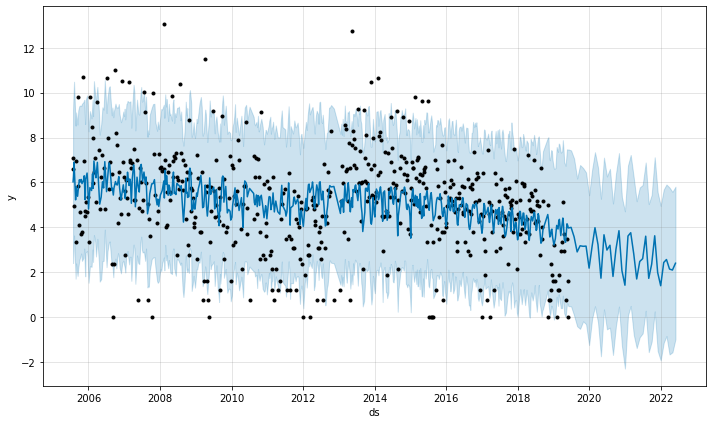

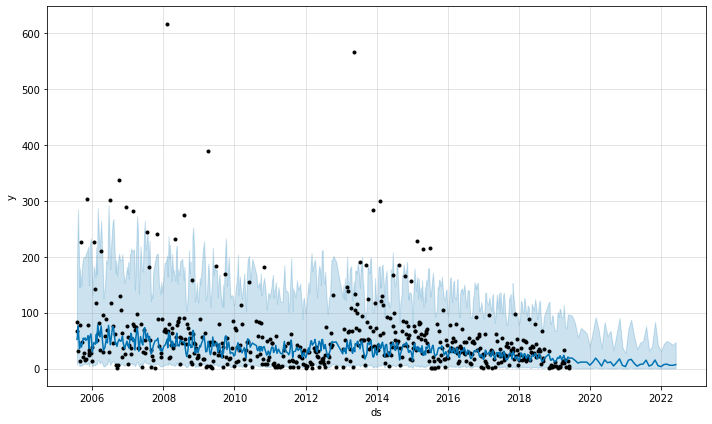

In [9]:
forecast_NT = forecastVariable(c.NT_CC, df, predictionMonths)
# forecast_NT[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


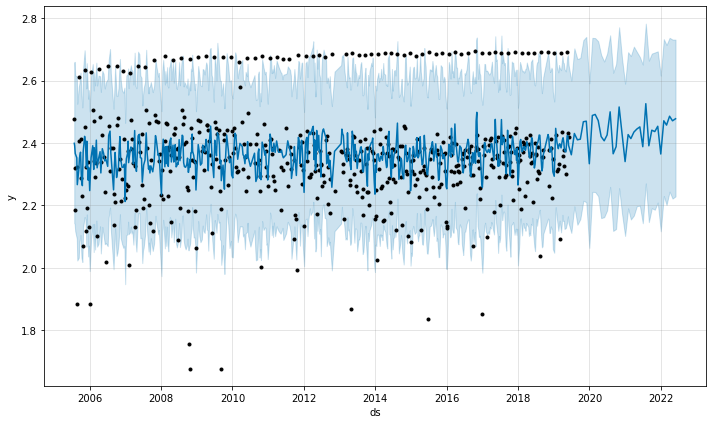

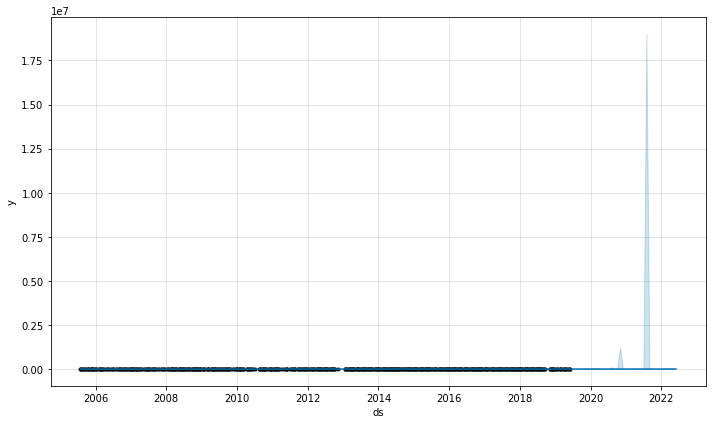

In [10]:

forecast_NO = forecastVariable(c.NO_CC, df, predictionMonths)
# forecast_NO[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


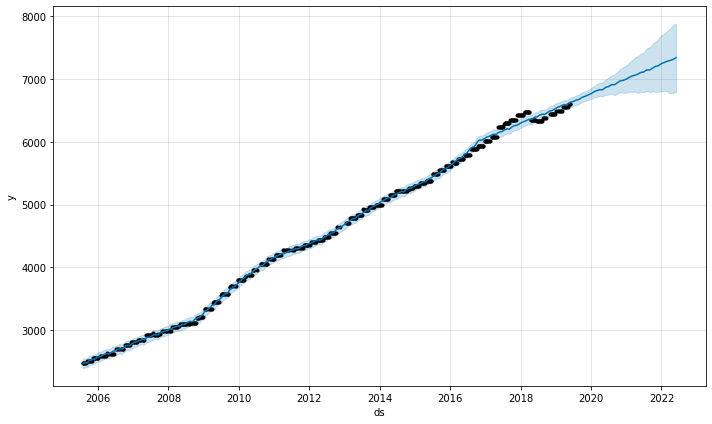

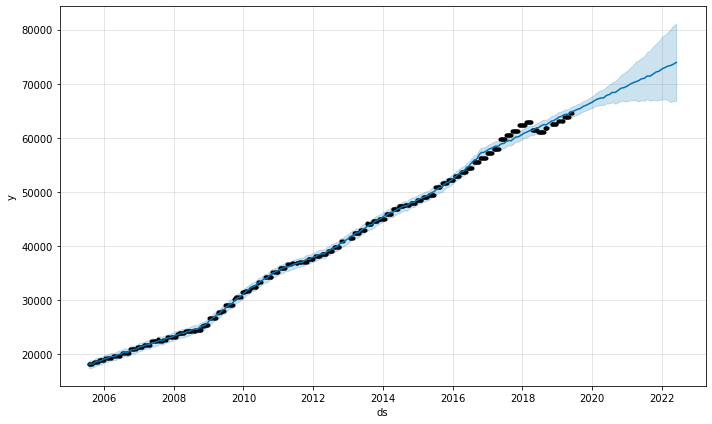

In [11]:
forecast_T_Module= forecastVariable(c.T_MODULE, df, predictionMonths)
# forecast_T_Module[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [12]:
data = {
    c.NT_CC: forecast_NT['yhat'],
    c.NO_CC: forecast_NO['yhat'],
    c.T_MODULE: forecast_T_Module['yhat']
}
dateIndex = forecast_NT['ds']
results = predictFutureEffort(data, dateIndex, c.MODULE_CC, rf_regressor)

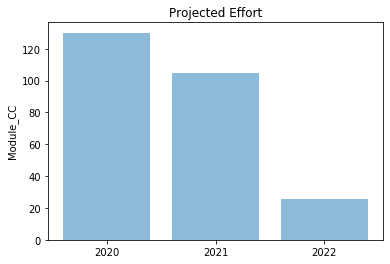

In [13]:
displayFutureEffort(results, c.MODULE_CC, predictionYears)

In [14]:
X = df[[c.NT_CC, c.NO_CC]]
Y = df[c.LINE_CC]
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.75, test_size=0.25, random_state=0)

In [15]:
rf_regressor = RandomForestRegressor(n_estimators=300, random_state=0)
rf_regressor.fit(X_train,y_train)
y_pred_rf = rf_regressor.predict(X_test)

In [16]:
data = {
    c.NT_CC: forecast_NT['yhat'],
    c.NO_CC: forecast_NO['yhat'],
}
dateIndex = forecast_NT['ds']
results = predictFutureEffort(data, dateIndex, c.LINE_CC, rf_regressor)

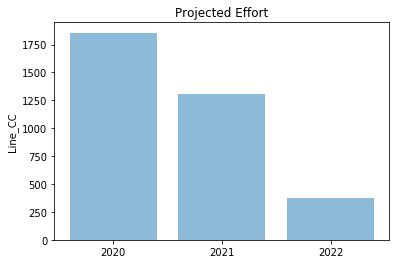

In [17]:
displayFutureEffort(results, c.LINE_CC, predictionYears)